In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import pickle
import os


In [25]:
heart_df = pd.read_csv('heart.csv')


In [26]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1025 non-null   int64  
 1    sex       1025 non-null   int64  
 2    cp        1025 non-null   int64  
 3    trestbps  1025 non-null   int64  
 4    chol      1025 non-null   int64  
 5    fbs       1025 non-null   int64  
 6    restecg   1025 non-null   int64  
 7    thalach   1025 non-null   int64  
 8    exang     1025 non-null   int64  
 9    oldpeak   1025 non-null   float64
 10   slope     1025 non-null   int64  
 11   ca        1025 non-null   int64  
 12   thal      1025 non-null   int64  
 13   target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


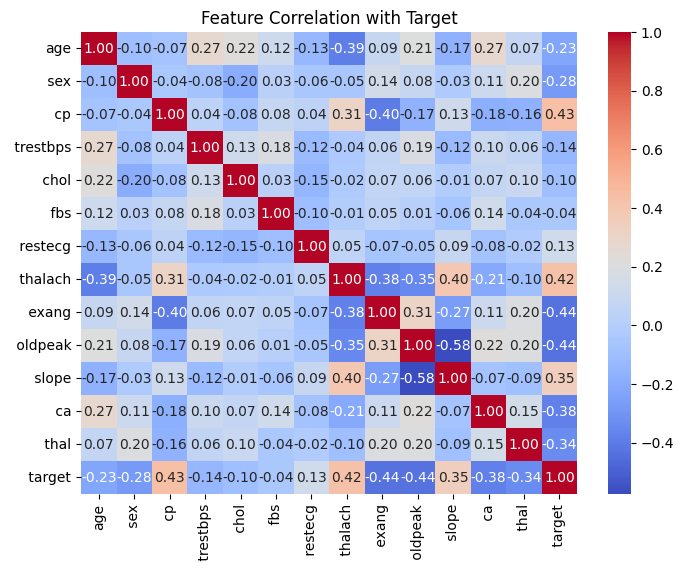

In [27]:
# Correlation heatmap for features and target
corr_matrix = heart_df.corr()
plt.figure(figsize=(8,6))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation with Target')
plt.show()

In [28]:
# there are more than 2 highly correlated features so Iam using PCA to reduce the dimensionality. although it improves the model performance

pca = PCA(n_components=2)


In [29]:
heart_df.columns = heart_df.columns.str.strip(' ')

In [30]:
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.apply(lambda x: upper if x > upper else lower if x < lower else x)

In [53]:
heart_df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [31]:
X = heart_df.drop('target',axis=1)
y = heart_df['target']
# handling outliers
X = X.apply(cap_outliers)
#scalling 
scaler = StandardScaler()
X_scales = scaler.fit_transform(X)
# Impute missing values after scaling
imputer = SimpleImputer(strategy='mean')
X_scales = imputer.fit_transform(X_scales)
# implementing PCA
X_pca = pca.fit_transform(X_scales)

In [32]:
X_pca
print("explaination...")
print(pca.explained_variance_ratio_)

explaination...
[0.23415946 0.12484415]


In [36]:
X_train,X_test,y_train,y_test = train_test_split(X_pca,y,test_size=0.2,random_state=42,shuffle=True)

In [37]:
# first model logistic regressor

lgr = LogisticRegression(random_state=45,verbose=1)
model2 = lgr.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [38]:
y_pred = lgr.predict(X_test)

In [39]:
log_acc = accuracy_score(y_test,y_pred)
log_prec = precision_score(y_test,y_pred)

print(f"Logistic regression analysis ={log_acc}\nprecision = {log_prec}")

Logistic regression analysis =0.7804878048780488
precision = 0.75


In [40]:
#using grid-search CV for hyperParameter tuning
parameters = {
    'random_state': [45],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=parameters,
    scoring={'accuracy': 'accuracy', 'precision': 'precision'},
    n_jobs=-1,
    verbose=1,
    refit='accuracy'
)
res = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [41]:
print('Using grid-search cv for hyper parameter tuning')
print(res.best_estimator_)
print(res.best_params_)
print(res.best_score_)

Using grid-search cv for hyper parameter tuning
DecisionTreeClassifier(max_depth=7, random_state=45)
{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 45}
0.9097560975609756


In [42]:
decisionTree = DecisionTreeClassifier(
    random_state=45,
    max_depth=7,           # Limit the depth of the tree
    min_samples_split=2,  # Require at least 10 samples to split a node
    min_samples_leaf=1     # Require at least 5 samples at a leaf node
)
model = decisionTree.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [43]:
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
prec2 = precision_score(y_true=y_test, y_pred=y_pred, average='binary')

In [44]:
print(f"Descision tree analysis\nAcc = {acc}\nprecision = {prec2}")

Descision tree analysis
Acc = 0.8975609756097561
precision = 0.8416666666666667


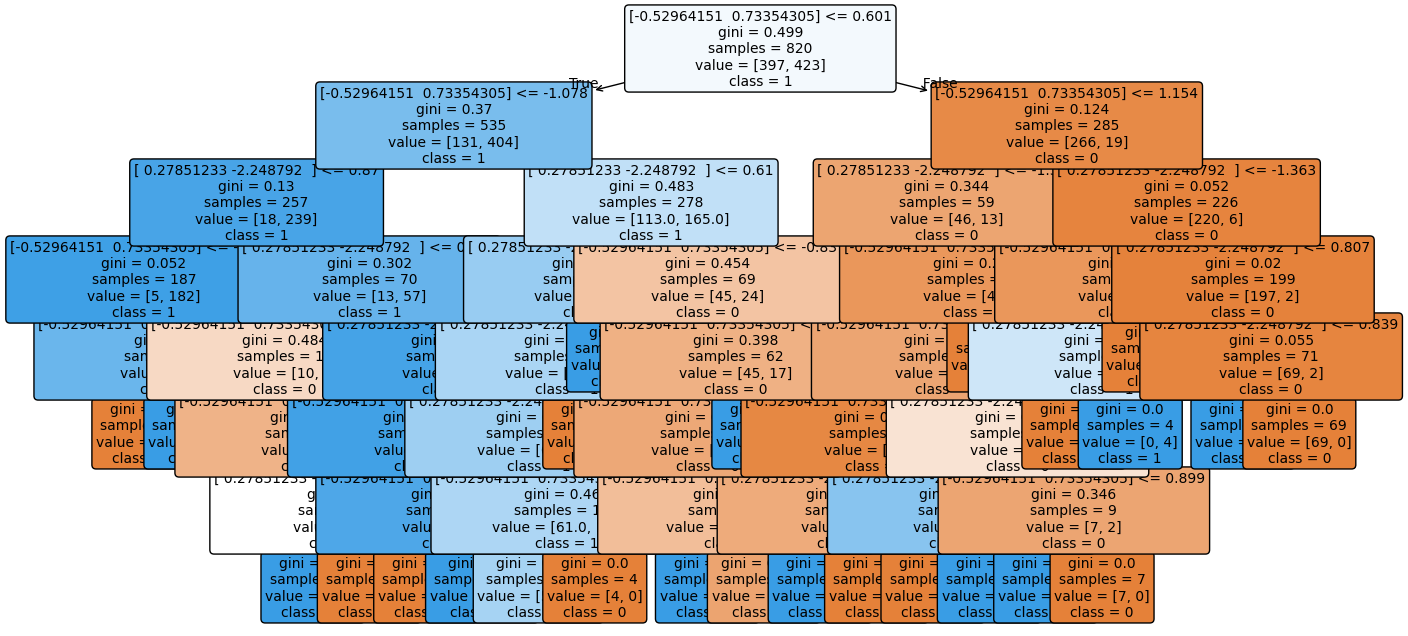

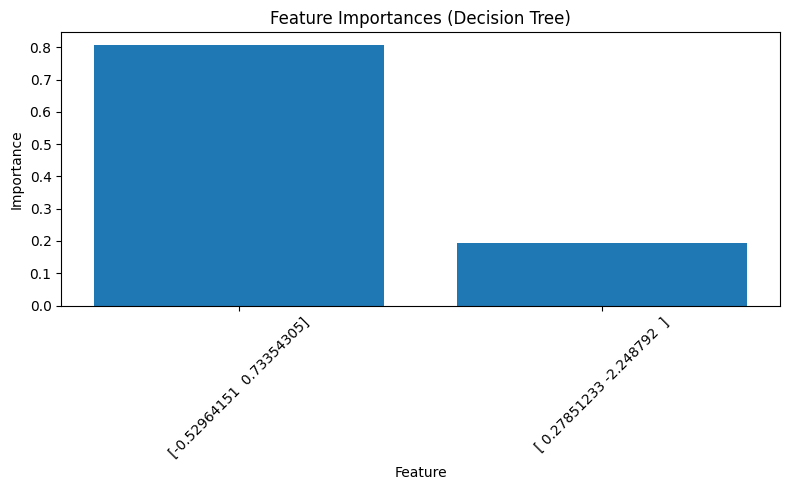

In [45]:
from sklearn.tree import plot_tree
plt.figure(figsize=(16,8))
plot_tree(
    model,
    feature_names=X_train,
    class_names=[str(cls) for cls in model.classes_],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

# Feature importance visualization
importances = model.feature_importances_
features = X_train
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title('Feature Importances (Decision Tree)')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), features[indices], rotation=45)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

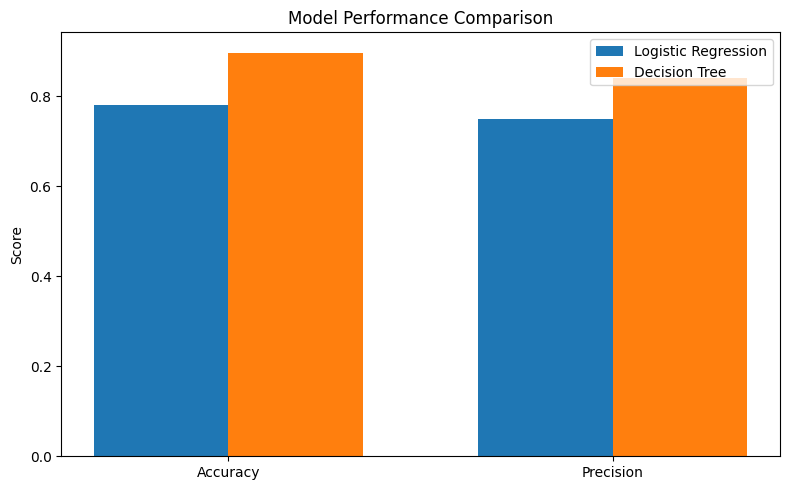

In [46]:
# Model performance comparison: Bar chart
metrics = ['Accuracy', 'Precision']
logistic_scores = [log_acc, log_prec]
tree_scores = [acc, prec2]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, logistic_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, tree_scores, width, label='Decision Tree')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

In [47]:
np.random.seed(42)
num_samples = 20
validation_data = {}
for col in heart_df.columns:
    if col == 'target':
        # Random binary targets
        validation_data[col] = np.random.randint(0, 2, size=num_samples)
    else:
        # Random values within the min/max of each feature
        col_min = heart_df[col].min()
        col_max = heart_df[col].max()
        validation_data[col] = np.random.uniform(col_min, col_max, size=num_samples)

valid = pd.DataFrame(validation_data)
valid = valid.reindex(columns=heart_df.columns)

In [51]:
# Preprocess validation data using the same scaler and PCA as training data
valid_features = valid.drop('target', axis=1)
valid_features = valid_features.apply(cap_outliers)
valid_features_scaled = scaler.transform(valid_features)
# Impute missing values in validation data using the same imputer
valid_features_scaled = imputer.transform(valid_features_scaled)
valid_features_pca = pca.transform(valid_features_scaled)
valid_pred = model.predict(valid_features_pca)
print('accuracy = ', accuracy_score(valid['target'].values, valid_pred))
print('Predictions:', valid_pred)
print('True labels:', valid['target'].values)

accuracy =  0.5
Predictions: [1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1]
True labels: [1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1]


In [54]:
#saving the model,imputer,and pca data

with open('decision_treeModel.pkl','wb') as m:
    pickle.dump(model,m)
    print('dumping complete')

with open('imputer_.pkl','wb') as m:
    pickle.dump(imputer,m)
    print('imputer dumping complete')

with open('scaler_.pkl','wb') as m:
    pickle.dump(scaler,m)
    print('imputer dumping complete')

with open('pca.pkl','wb') as m:
    pickle.dump(pca,m)
    print('pca dumping complete')

dumping complete
imputer dumping complete
imputer dumping complete
pca dumping complete


In [ ]:
### using strimlit ------
! pip install streamlit